Get the OpenSky data: https://zenodo.org/record/5815402#.YejFKFhuc6B

This is the file that helps with reading in and cleaning up the data from OpenSky: https://github.com/ActiveConclusion/COVID19_AirTraffic/blob/master/Air%20Traffic.ipynb

Import necessary packages

In [90]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections

Get three months (Jan,Feb,Mar) of 2021 OpenSky data and store it in variable flightlist. Make sure to change the path to where you are storing the flightlist datasets. You can look at even more months by downloading more months from the OpenSky website. There will be a lot of rows so we will just look at three months since we are working on a local computer.

In [92]:
flightlist = pd.concat(
    pd.read_csv(file, parse_dates=["firstseen", "lastseen", "day"])
    for file in Path("Desktop/Stats_M148/OpenSky/2021gz").glob("flightlist_*.csv.gz")
)

In [3]:
flightlist.head() #Look at the first five entries

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,ETH3505,NaN,04014b,NaN,NaN,NaN,SBMT,2021-10-31 00:24:44+00:00,2021-11-01 00:28:26+00:00,2021-11-01 00:00:00+00:00,28.156174,108.287166,10972.8,-23.421387,-46.715915,1676.40
1,ACP020,NaN,04c27e,NaN,NaN,OMDW,FAOR,2021-10-31 00:37:33+00:00,2021-11-01 00:20:55+00:00,2021-11-01 00:00:00+00:00,24.900467,55.154317,0.0,-26.198318,28.218539,1973.58
2,BAV9027,NaN,8881b3,NaN,NaN,RJAA,EGLL,2021-10-31 01:39:10+00:00,2021-11-01 06:28:19+00:00,2021-11-01 00:00:00+00:00,35.829861,140.328135,914.4,51.464951,-0.434777,205.74
3,ETH3720,NaN,040143,NaN,NaN,NaN,EIDW,2021-10-31 01:45:29+00:00,2021-11-01 07:57:59+00:00,2021-11-01 00:00:00+00:00,9.171443,74.423470,12192.0,53.419830,-6.242824,297.18
4,ADB387F,NaN,50801c,UR-82008,A124,NaN,EDDP,2021-10-31 01:47:15+00:00,2021-11-01 05:01:47+00:00,2021-11-01 00:00:00+00:00,17.649628,-67.322388,9144.0,51.413502,12.246246,236.22


We want to get rid of entries that have missing origin and destination.

In [4]:
flightlist = flightlist[flightlist['origin'].notna() & flightlist['destination'].notna()]

## We want to match ICAO codes table to get meaningful Country names

The origin and destination are in ICAO codes, so we want to download ICAO codes table that matches each ICAO code to a country.

In [3]:
icao_codes = pd.read_excel(Path("Desktop/Stats_M148/auxiliary_data/icao_codes.xlsx"), usecols=["ICAO", "Country"], sheet_name = "data")

In [4]:
icao_codes.head()

,ICAO,Country
0,AGAF,Solomon Islands
1,AGAR,Solomon Islands
2,AGAT,Solomon Islands
3,AGBT,Solomon Islands
4,AGGA,Solomon Islands


First, we want to join by Origin

In [93]:
flightlist = pd.merge(flightlist, icao_codes, how="left", left_on = ["origin"], right_on=["ICAO"])
flightlist = flightlist.rename(columns={"Country": "country_origin"}).drop(columns=["ICAO"])

Next, we want to join by Destination

In [8]:
flightlist = pd.merge(flightlist, icao_codes, how="left", left_on = ["destination"], right_on=["ICAO"])
flightlist = flightlist.rename(columns={"Country": "country_destination"}).drop(columns=["ICAO"])

In [9]:
flightlist.head() #The countries are now more meaningful

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
0,ACP020,NaN,04c27e,NaN,NaN,OMDW,FAOR,2021-10-31 00:37:33+00:00,2021-11-01 00:20:55+00:00,2021-11-01 00:00:00+00:00,24.900467,55.154317,0.0,-26.198318,28.218539,1973.58,United Arab Emirates,South Africa
1,BAV9027,NaN,8881b3,NaN,NaN,RJAA,EGLL,2021-10-31 01:39:10+00:00,2021-11-01 06:28:19+00:00,2021-11-01 00:00:00+00:00,35.829861,140.328135,914.4,51.464951,-0.434777,205.74,Japan,United Kingdom
2,ETH712,NaN,040087,ET-ARE,B788,KJFK,LIRF,2021-10-31 02:04:58+00:00,2021-11-01 02:34:21+00:00,2021-11-01 00:00:00+00:00,40.636734,-73.697449,609.6,41.853058,12.258557,83.82,United States of America,Italy
3,ACI140S,NaN,3a3493,F-ONET,A339,RJAA,YSSY,2021-10-31 04:04:05+00:00,2021-11-01 00:28:45+00:00,2021-11-01 00:00:00+00:00,35.832701,140.326148,914.4,-34.004517,151.202536,114.30,Japan,Australia
4,CSN425,NaN,7805a9,B-2073,B77L,KLAX,EGSS,2021-10-31 04:39:46+00:00,2021-11-01 11:11:17+00:00,2021-11-01 00:00:00+00:00,33.933975,-118.416586,0.0,51.898727,0.255432,312.42,United States of America,United Kingdom


From this join on country origin and country destination, we want to check the percentage of missing values compared to the whole dataset.

In [10]:
print(f"Number of Flights: {len(flightlist)}")
print(f"Missing Values for Country Origin: {flightlist.country_origin.isnull().sum(axis = 0) / len(flightlist)}")
print(f"Missing Values for Country Destination: {flightlist.country_destination.isnull().sum(axis = 0) / len(flightlist)}")

Number of Flights: 4957387
Missing Values for Country Origin: 0.15444628389915896
Missing Values for Country Destination: 0.2056666142869217


Remove records which didn't match with any country origin or country desstination

In [11]:
flightlist = flightlist[flightlist['country_origin'].notna() & flightlist['country_destination'].notna()]

In [12]:
flightlist.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
0,ACP020,NaN,04c27e,NaN,NaN,OMDW,FAOR,2021-10-31 00:37:33+00:00,2021-11-01 00:20:55+00:00,2021-11-01 00:00:00+00:00,24.900467,55.154317,0.0,-26.198318,28.218539,1973.58,United Arab Emirates,South Africa
1,BAV9027,NaN,8881b3,NaN,NaN,RJAA,EGLL,2021-10-31 01:39:10+00:00,2021-11-01 06:28:19+00:00,2021-11-01 00:00:00+00:00,35.829861,140.328135,914.4,51.464951,-0.434777,205.74,Japan,United Kingdom
2,ETH712,NaN,040087,ET-ARE,B788,KJFK,LIRF,2021-10-31 02:04:58+00:00,2021-11-01 02:34:21+00:00,2021-11-01 00:00:00+00:00,40.636734,-73.697449,609.6,41.853058,12.258557,83.82,United States of America,Italy
3,ACI140S,NaN,3a3493,F-ONET,A339,RJAA,YSSY,2021-10-31 04:04:05+00:00,2021-11-01 00:28:45+00:00,2021-11-01 00:00:00+00:00,35.832701,140.326148,914.4,-34.004517,151.202536,114.30,Japan,Australia
4,CSN425,NaN,7805a9,B-2073,B77L,KLAX,EGSS,2021-10-31 04:39:46+00:00,2021-11-01 11:11:17+00:00,2021-11-01 00:00:00+00:00,33.933975,-118.416586,0.0,51.898727,0.255432,312.42,United States of America,United Kingdom


Remove timezone information from "day" column

In [13]:
flightlist['day'] = flightlist['day'].dt.date

Now we want to select busiest United States airports.
From Wikipedia: https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States
These are the top ten busiest airports in the US.
"KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"

If we look at all flights where the origin in KSEA, we see that there are 34000 rows of data in just three months. That is why we want to look at something specific because creating graphs for all airports will take too long to run on the local computer.

In [64]:
flightlist[flightlist["origin"] == "KSEA"]

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
401,DAL167,DL167,a4bf95,N405DX,NaN,KSEA,RJTT,2021-10-31 19:26:29+00:00,2021-11-01 05:06:55+00:00,2021-11-01,47.454071,-122.307838,0.0,35.483605,139.823232,327.66,United States of America,Japan
444,DAL197,DL197,a4b827,N403DX,NaN,KSEA,RKSI,2021-10-31 19:45:07+00:00,2021-11-01 07:03:58+00:00,2021-11-01,47.450696,-122.307904,0.0,37.426184,126.491626,152.40,United States of America,"Korea, Republic of"
534,DAL869,DL869,a7a9cd,N593NW,B753,KSEA,KATL,2021-10-31 20:19:07+00:00,2021-11-01 00:22:38+00:00,2021-11-01,47.445855,-122.307904,0.0,33.649587,-84.405098,297.18,United States of America,United States of America
626,AAR271,OZ271,71c259,HL8259,A333,KSEA,RKSI,2021-10-31 20:44:11+00:00,2021-11-01 08:21:30+00:00,2021-11-01,47.443726,-122.308113,0.0,37.426649,126.491089,137.16,United States of America,"Korea, Republic of"
682,UAL2275,NaN,a13651,N17753,B737,KSEA,KIAD,2021-10-31 20:58:16+00:00,2021-11-01 01:14:23+00:00,2021-11-01,47.450958,-122.307838,0.0,38.929774,-77.436340,83.82,United States of America,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4954633,SKW5320,NaN,a0e5d7,N157SY,E75L,KSEA,KLAX,2021-10-31 21:43:36+00:00,2021-10-31 23:59:28+00:00,2021-10-31,47.443542,-122.307907,0.0,33.953110,-118.392371,83.82,United States of America,United States of America
4956008,ASA475,AS475,a37986,N323AS,B739,KSEA,KRNO,2021-10-31 22:20:43+00:00,2021-10-31 23:38:10+00:00,2021-10-31,47.440842,-122.307976,0.0,39.513539,-119.769226,1356.36,United States of America,United States of America
4956246,SKW3808,NaN,a2d710,NaN,NaN,KSEA,CYVR,2021-10-31 22:29:45+00:00,2021-10-31 22:56:38+00:00,2021-10-31,47.437134,-122.307976,0.0,49.198826,-123.145246,60.96,United States of America,Canada
4956481,SKW145H,NaN,a29e5c,N268SY,NaN,KSEA,KEUG,2021-10-31 22:39:01+00:00,2021-10-31 23:23:59+00:00,2021-10-31,47.444924,-122.307904,0.0,44.059691,-123.225468,449.58,United States of America,United States of America


Next we subset the flightlist where origin is from the top ten busiest aiports in the US with the isin function.

In [14]:
subset2021 = flightlist[flightlist['origin'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"]) ]

In [15]:
subset2021

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
4,CSN425,NaN,7805a9,B-2073,B77L,KLAX,EGSS,2021-10-31 04:39:46+00:00,2021-11-01 11:11:17+00:00,2021-11-01,33.933975,-118.416586,0.0,51.898727,0.255432,312.42,United States of America,United Kingdom
8,QFA7552,NaN,aba800,N850GT,B748,KLAX,YSSY,2021-10-31 07:05:20+00:00,2021-11-01 03:27:59+00:00,2021-11-01,33.933230,-118.423405,0.0,-33.973590,151.183033,-15.24,United States of America,Australia
35,CAL5155,NaN,8990a5,NaN,NaN,KLAX,RJBB,2021-10-31 11:55:18+00:00,2021-11-01 00:06:46+00:00,2021-11-01,33.936264,-118.415185,0.0,34.419840,135.232887,-91.44,United States of America,Japan
84,CKS998,NaN,aa01a2,N744CK,B744,KLAX,RKSI,2021-10-31 14:36:19+00:00,2021-11-01 03:24:15+00:00,2021-11-01,33.936218,-118.414624,0.0,37.433212,126.485304,106.68,United States of America,"Korea, Republic of"
112,ABW708,RU708,42435f,VP-BJC,G650,KORD,UUEE,2021-10-31 15:39:53+00:00,2021-11-01 00:07:47+00:00,2021-11-01,41.968735,-87.949240,304.8,55.985071,37.489214,304.80,United States of America,Russian Federation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957050,N885MH,NaN,ac3183,N885MH,EC30,KLAS,KVGT,2021-10-31 23:05:36+00:00,2021-10-31 23:20:18+00:00,2021-10-31,36.079427,-115.170788,609.6,36.102936,-115.394488,1478.28,United States of America,United States of America
4957065,RPA3582,YX3582,a9fc34,N742YX,E75L,KORD,KIND,2021-10-31 23:06:38+00:00,2021-10-31 23:37:24+00:00,2021-10-31,41.968984,-87.924798,304.8,39.750778,-86.264290,396.24,United States of America,United States of America
4957106,DAL2789,DL2789,acf497,N934AT,B712,KATL,KCLT,2021-10-31 23:08:50+00:00,2021-10-31 23:47:15+00:00,2021-10-31,33.634552,-84.431501,304.8,35.141235,-80.960158,571.50,United States of America,United States of America
4957112,SWA6175,WN6175,abb8c4,N8541W,B738,KLAS,KSNA,2021-10-31 23:09:08+00:00,2021-10-31 23:48:36+00:00,2021-10-31,36.076402,-115.132394,609.6,33.716721,-117.842887,243.84,United States of America,United States of America


It seems like there a lot of rows for origins that are from the top ten US airports, lets try to narrow it down so that the destination is also part of these top ten airports.

In [16]:
subset2021 = flightlist[(flightlist['origin'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) & (flightlist['destination'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) ]

In [17]:
subset2021

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
218,DAL630,DL630,a6ec52,N545US,B752,KLAX,KLAX,2021-10-31 16:48:54+00:00,2021-11-01 01:42:29+00:00,2021-11-01,33.947800,-118.424602,0.0,33.953107,-118.392048,83.82,United States of America,United States of America
238,UAL766,NaN,a60814,N488UA,A320,KLAX,KORD,2021-10-31 17:10:55+00:00,2021-11-01 00:20:55+00:00,2021-11-01,33.937000,-118.408756,0.0,41.965772,-87.870441,259.08,United States of America,United States of America
246,AAL828,AA828,aa64ca,N769US,A319,KLAX,KCLT,2021-10-31 17:13:47+00:00,2021-11-01 00:36:41+00:00,2021-11-01,33.936630,-118.411317,0.0,35.159271,-80.930506,457.20,United States of America,United States of America
253,AAL502,AA502,a03ce6,N114UW,A320,KPHX,KPHX,2021-10-31 17:24:37+00:00,2021-11-01 02:35:48+00:00,2021-11-01,33.431076,-112.014404,304.8,33.428833,-112.009131,335.28,United States of America,United States of America
278,UAL798,NaN,a56dcf,N449UA,A320,KDEN,KLAX,2021-10-31 17:44:03+00:00,2021-11-01 00:03:59+00:00,2021-11-01,39.864078,-104.687195,1524.0,33.938644,-118.370006,83.82,United States of America,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956638,SWA4652,WN4652,a4f022,N417WN,B737,KLAX,KPHX,2021-10-31 22:45:00+00:00,2021-10-31 23:41:16+00:00,2021-10-31,33.947937,-118.424377,0.0,33.431024,-112.000178,335.28,United States of America,United States of America
4956658,SKW3921,OO3921,a31890,N299SY,NaN,KLAX,KPHX,2021-10-31 22:45:49+00:00,2021-10-31 23:47:08+00:00,2021-10-31,33.948545,-118.418541,0.0,33.428836,-112.012678,350.52,United States of America,United States of America
4956701,AAL1701,AA1701,a5012d,NaN,NaN,KPHX,KLAX,2021-10-31 22:47:42+00:00,2021-10-31 23:46:28+00:00,2021-10-31,33.431076,-112.002924,304.8,33.938828,-118.368381,99.06,United States of America,United States of America
4956864,N821MH,NaN,ab35ad,N821MH,EC30,KLAS,KLAS,2021-10-31 22:55:30+00:00,2021-10-31 23:06:58+00:00,2021-10-31,36.080566,-115.170135,609.6,36.080383,-115.170250,693.42,United States of America,United States of America


We have reduced the number of rows for our dataset. Lets look at the flights from LAX to LAX to see if there will be self loops in our network graph.

In [76]:
subset2021[(subset2021["origin"]=="KLAX") & (subset2021["destination"]=="KLAX")]

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
218,DAL630,DL630,a6ec52,N545US,B752,KLAX,KLAX,2021-10-31 16:48:54+00:00,2021-11-01 01:42:29+00:00,2021-11-01,33.947800,-118.424602,0.0,33.953107,-118.392048,83.82,United States of America,United States of America
35392,DAL630,DL630,a6c4d3,N535US,B752,KLAX,KLAX,2021-11-01 16:25:45+00:00,2021-11-02 01:13:59+00:00,2021-11-02,33.947614,-118.427124,0.0,33.938211,-118.374424,38.10,United States of America,United States of America
41964,AAL2546,AA2546,aa55ee,N765US,A319,KLAX,KLAX,2021-11-01 18:11:43+00:00,2021-11-02 04:00:53+00:00,2021-11-02,33.936447,-118.413671,0.0,33.938049,-118.376452,15.24,United States of America,United States of America
91976,DAL630,DL630,a6fb2e,N549US,B752,KLAX,KLAX,2021-11-02 16:22:57+00:00,2021-11-03 01:07:15+00:00,2021-11-03,33.947708,-118.426115,0.0,33.938370,-118.372641,45.72,United States of America,United States of America
94848,AAL2546,AA2546,aa55ee,N765US,A319,KLAX,KLAX,2021-11-02 17:14:14+00:00,2021-11-03 01:17:28+00:00,2021-11-03,33.936162,-118.416882,0.0,33.938816,-118.368130,60.96,United States of America,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4809866,MAA1852,M71852,aa7442,N773AX,B762,KLAX,KLAX,2021-10-29 05:22:40+00:00,2021-10-29 16:51:22+00:00,2021-10-29,33.936349,-118.413963,0.0,33.938416,-118.372473,91.44,United States of America,United States of America
4835771,DAL630,DL630,a6cc41,N537US,B752,KLAX,KLAX,2021-10-29 16:35:33+00:00,2021-10-30 01:06:59+00:00,2021-10-30,33.947159,-118.430655,0.0,33.938350,-118.372650,114.30,United States of America,United States of America
4839344,AAL2546,AA2546,ab586f,N830AW,A319,KLAX,KLAX,2021-10-29 17:36:58+00:00,2021-10-30 01:31:06+00:00,2021-10-30,33.936722,-118.410925,0.0,33.937885,-118.377514,91.44,United States of America,United States of America
4888905,DAL630,DL630,a6ec52,N545US,B752,KLAX,KLAX,2021-10-30 16:23:53+00:00,2021-10-31 01:14:47+00:00,2021-10-31,33.947159,-118.431328,0.0,33.937885,-118.377571,68.58,United States of America,United States of America


There are only 277 flights from LA to LA. That seems reasonable because I don't think the majority of travelers want to travel from LA to LA.

We want to get a dictionary of the edges (flights origin, flight destination) and their counts (number of these directed flights.

In [18]:
flightCount = {}

We can use the Counter from collections to create a dictionary.

In [20]:
flightCount = collections.Counter(flight for flight in zip(subset2021["origin"],subset2021["destination"]))

In [21]:
flightCount

Counter({('KLAX', 'KLAX'): 277,
         ('KLAX', 'KORD'): 1643,
         ('KLAX', 'KCLT'): 548,
         ('KPHX', 'KPHX'): 355,
         ('KDEN', 'KLAX'): 2028,
         ('KDEN', 'KORD'): 1899,
         ('KDFW', 'KDFW'): 554,
         ('KATL', 'KLAX'): 1214,
         ('KMCO', 'KLAS'): 375,
         ('KSEA', 'KATL'): 807,
         ('KORD', 'KLAX'): 1434,
         ('KLAX', 'KATL'): 1268,
         ('KCLT', 'KLAX'): 517,
         ('KORD', 'KLAS'): 1317,
         ('KLAS', 'KMCO'): 371,
         ('KORD', 'KSEA'): 1322,
         ('KDEN', 'KDEN'): 207,
         ('KATL', 'KLAS'): 1142,
         ('KSEA', 'KORD'): 1358,
         ('KPHX', 'KATL'): 783,
         ('KATL', 'KDEN'): 1224,
         ('KMCO', 'KDEN'): 831,
         ('KLAS', 'KATL'): 1161,
         ('KSEA', 'KDFW'): 757,
         ('KMCO', 'KLAX'): 719,
         ('KATL', 'KSEA'): 834,
         ('KLAX', 'KDFW'): 1473,
         ('KSEA', 'KDEN'): 1478,
         ('KDEN', 'KSEA'): 1535,
         ('KDFW', 'KCLT'): 943,
         ('KSEA', 'KLAX')

Next we want to create a dataframe from this dictionary to be able to pass it into networkX to create a graph.

In [22]:
dataFrameList = []
for origin,destination in flightCount:
        dataFrameList.append(
        {
            'Origin': origin,
            'Destination': destination,
            'Count': flightCount[origin,destination]
        }
    )

In [23]:
flightCountDF = pd.DataFrame(dataFrameList)

In [24]:
flightCountDF

,Origin,Destination,Count
0,KLAX,KLAX,277
1,KLAX,KORD,1643
2,KLAX,KCLT,548
3,KPHX,KPHX,355
4,KDEN,KLAX,2028
...,...,...,...
95,KATL,KATL,314
96,KMCO,KMCO,182
97,KCLT,KSEA,195
98,KMCO,KDFW,993


In [25]:
#len(flightCount)

100

We can know create a graph from flightCountDF using networkx

In [26]:
G = nx.from_pandas_edgelist(flightCountDF, "Origin", "Destination", ["Count"], create_using=nx.Graph)

We can access the metadata of our edges, which is a dictionary of the counts of the specific flight

In [27]:
G.edges(data=True)

EdgeDataView([('KLAX', 'KLAX', {'Count': 277}), ('KLAX', 'KORD', {'Count': 1434}), ('KLAX', 'KCLT', {'Count': 517}), ('KLAX', 'KDEN', {'Count': 1856}), ('KLAX', 'KATL', {'Count': 1268}), ('KLAX', 'KMCO', {'Count': 732}), ('KLAX', 'KDFW', {'Count': 1460}), ('KLAX', 'KSEA', {'Count': 1835}), ('KLAX', 'KLAS', {'Count': 2836}), ('KLAX', 'KPHX', {'Count': 2057}), ('KORD', 'KDEN', {'Count': 1694}), ('KORD', 'KLAS', {'Count': 1313}), ('KORD', 'KSEA', {'Count': 1358}), ('KORD', 'KMCO', {'Count': 1218}), ('KORD', 'KATL', {'Count': 1576}), ('KORD', 'KPHX', {'Count': 1477}), ('KORD', 'KDFW', {'Count': 1510}), ('KORD', 'KCLT', {'Count': 999}), ('KORD', 'KORD', {'Count': 225}), ('KCLT', 'KDFW', {'Count': 897}), ('KCLT', 'KDEN', {'Count': 745}), ('KCLT', 'KATL', {'Count': 1322}), ('KCLT', 'KLAS', {'Count': 664}), ('KCLT', 'KSEA', {'Count': 195}), ('KCLT', 'KPHX', {'Count': 557}), ('KCLT', 'KMCO', {'Count': 952}), ('KCLT', 'KCLT', {'Count': 540}), ('KPHX', 'KPHX', {'Count': 355}), ('KPHX', 'KATL', {'

We can generate the position for the top ten aiport nodes and store it in variable pos so we can fix the position of node when we visualize.

In [28]:
pos = nx.circular_layout(G) #Uses the Fruchterman-Reingold force-directed algorith, to position nodes and minimize overlapping
pos 

{'KLAX': array([1.00000000e+00, 2.66236709e-08]),
 'KORD': array([0.809017  , 0.58778527]),
 'KCLT': array([0.30901698, 0.95105656]),
 'KPHX': array([-0.30901702,  0.9510565 ]),
 'KDEN': array([-0.80901705,  0.58778521]),
 'KDFW': array([-9.99999982e-01, -6.07991049e-08]),
 'KATL': array([-0.80901693, -0.58778533]),
 'KMCO': array([-0.30901708, -0.95105645]),
 'KLAS': array([ 0.30901713, -0.95105645]),
 'KSEA': array([ 0.80901694, -0.58778527])}

If we want to get the number label corresponding to an airport we can use a dictionary comprehension. It turns out we don't need this.

In [29]:
numberToAirport = {i+1 : airport for i , airport in enumerate(pos)}
numberToAirport

{1: 'KLAX',
 2: 'KORD',
 3: 'KCLT',
 4: 'KPHX',
 5: 'KDEN',
 6: 'KDFW',
 7: 'KATL',
 8: 'KMCO',
 9: 'KLAS',
 10: 'KSEA'}

If we want the opposite where an airport corresponds to an number label, we can use a dictionary comprehension. Turns out we don't need this.

In [30]:
airportToNumber = {airport: i for i, airport in numberToAirport.items()}
airportToNumber

{'KLAX': 1,
 'KORD': 2,
 'KCLT': 3,
 'KPHX': 4,
 'KDEN': 5,
 'KDFW': 6,
 'KATL': 7,
 'KMCO': 8,
 'KLAS': 9,
 'KSEA': 10}

We can map the origin and destination names using our dictionary. However, it turns out we don't need this as networkx doesn't require the nodes to be a number instead of a string of the airport name.

In [31]:
flightCountNumDF = pd.DataFrame()

In [32]:
flightCountNumDF["Origin"] = flightCountDF["Origin"].map(airportToNumber)

In [33]:
flightCountNumDF["Destination"] = flightCountDF["Destination"].map(airportToNumber)

In [34]:
flightCountNumDF["Count"] = flightCountDF["Count"]

In [35]:
flightCountNumDF

,Origin,Destination,Count
0,1,1,277
1,1,2,1643
2,1,3,548
3,4,4,355
4,5,1,2028
...,...,...,...
95,7,7,314
96,8,8,182
97,3,10,195
98,8,6,993


If we create the graph again, we have the airports as numbers instead of a string.

In [102]:
G = nx.from_pandas_edgelist(flightCountNumDF, "Origin", "Destination", ["Count"], create_using=nx.Graph)

NameError: name 'flightCountNumDF' is not defined

In [37]:
G.edges(data=True)

EdgeDataView([(1, 1, {'Count': 277}), (1, 2, {'Count': 1434}), (1, 3, {'Count': 517}), (1, 5, {'Count': 1856}), (1, 7, {'Count': 1268}), (1, 8, {'Count': 732}), (1, 6, {'Count': 1460}), (1, 10, {'Count': 1835}), (1, 9, {'Count': 2836}), (1, 4, {'Count': 2057}), (2, 5, {'Count': 1694}), (2, 9, {'Count': 1313}), (2, 10, {'Count': 1358}), (2, 8, {'Count': 1218}), (2, 7, {'Count': 1576}), (2, 4, {'Count': 1477}), (2, 6, {'Count': 1510}), (2, 3, {'Count': 999}), (2, 2, {'Count': 225}), (3, 6, {'Count': 897}), (3, 5, {'Count': 745}), (3, 7, {'Count': 1322}), (3, 9, {'Count': 664}), (3, 10, {'Count': 195}), (3, 4, {'Count': 557}), (3, 8, {'Count': 952}), (3, 3, {'Count': 540}), (4, 4, {'Count': 355}), (4, 7, {'Count': 779}), (4, 6, {'Count': 1015}), (4, 10, {'Count': 1554}), (4, 8, {'Count': 355}), (4, 5, {'Count': 1935}), (4, 9, {'Count': 1612}), (5, 5, {'Count': 207}), (5, 7, {'Count': 1244}), (5, 8, {'Count': 828}), (5, 10, {'Count': 1535}), (5, 6, {'Count': 1231}), (5, 9, {'Count': 1831})

In [38]:
pos = nx.circular_layout(G) #Uses the Fruchterman-Reingold force-directed algorith, to position nodes and minimize overlapping
pos 

{1: array([1.00000000e+00, 2.66236709e-08]),
 2: array([0.809017  , 0.58778527]),
 3: array([0.30901698, 0.95105656]),
 4: array([-0.30901702,  0.9510565 ]),
 5: array([-0.80901705,  0.58778521]),
 6: array([-9.99999982e-01, -6.07991049e-08]),
 7: array([-0.80901693, -0.58778533]),
 8: array([-0.30901708, -0.95105645]),
 9: array([ 0.30901713, -0.95105645]),
 10: array([ 0.80901694, -0.58778527])}

Now we can create a list of the edge_widths that corresponds to the number of flights for a specific directed edge. We need a small scaling_factor so the numbers don't get too big.

In [39]:
#Get a list of the edge weights and if needed, multiply by a scaling factor for visibility
scaling_factor = 0.01 #scaling factor for the edges, play with it till it works
edge_widths = [scaling_factor * G.edges[i]['Count'] for i in G.edges]
print(edge_widths)

[2.77, 14.34, 5.17, 18.56, 12.68, 7.32, 14.6, 18.35, 28.36, 20.57, 16.94, 13.13, 13.58, 12.18, 15.76, 14.77, 15.1, 9.99, 2.25, 8.97, 7.45, 13.22, 6.640000000000001, 1.95, 5.57, 9.52, 5.4, 3.5500000000000003, 7.79, 10.15, 15.540000000000001, 3.5500000000000003, 19.35, 16.12, 2.07, 12.44, 8.28, 15.35, 12.31, 18.31, 5.54, 8.75, 15.22, 12.02, 9.93, 8.34, 11.61, 17.71, 3.14, 3.71, 4.03, 1.82, 14.290000000000001, 19.71, 0.59]


We can now plot the number of flights for the top ten aiports.

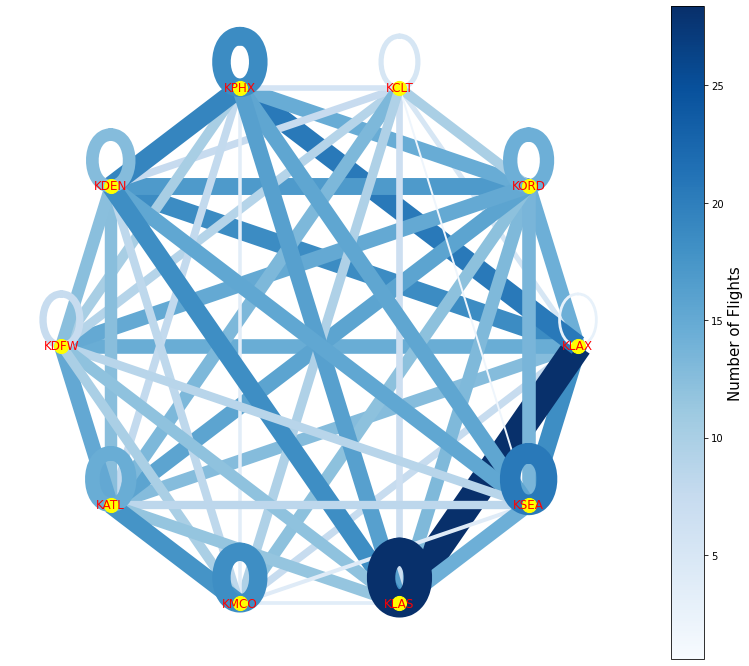

In [46]:
fig, ax = plt.subplots(figsize = (14, 12)) #Create 14 (width) inches x 12 (height) inches figure (to make room for the colorbar)
cmap = plt.cm.Blues #store the colormap in the variable cmap
nx.draw(G, pos, ax = ax, node_color = 'yellow', node_size = 200, 
        width = edge_widths, edge_color = edge_widths, edge_cmap=cmap,labels=numberToAirport, with_labels = True,font_color="red") #Draw the network with edge width based on the edge weight

vmin = min(edge_widths) #Calculate the min and max values of the colorbar
vmax = max(edge_widths)
#Plot and show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Number of Flights', fontsize = 15)
# plt.savefig('ThickAirportNetworkGraph.png') #save the image

It seems like the edge_widths are very large, lets try to lower this by making the scaling factor even smaller.

We can then plot a thinner version of the circular network.

[0.277, 1.434, 0.517, 1.856, 1.268, 0.732, 1.46, 1.835, 2.836, 2.057, 1.694, 1.313, 1.358, 1.218, 1.576, 1.477, 1.51, 0.999, 0.225, 0.897, 0.745, 1.322, 0.664, 0.195, 0.557, 0.9520000000000001, 0.54, 0.355, 0.779, 1.0150000000000001, 1.554, 0.355, 1.935, 1.612, 0.20700000000000002, 1.244, 0.8280000000000001, 1.5350000000000001, 1.231, 1.831, 0.554, 0.875, 1.522, 1.202, 0.993, 0.834, 1.161, 1.7710000000000001, 0.314, 0.371, 0.403, 0.182, 1.429, 1.971, 0.059000000000000004]


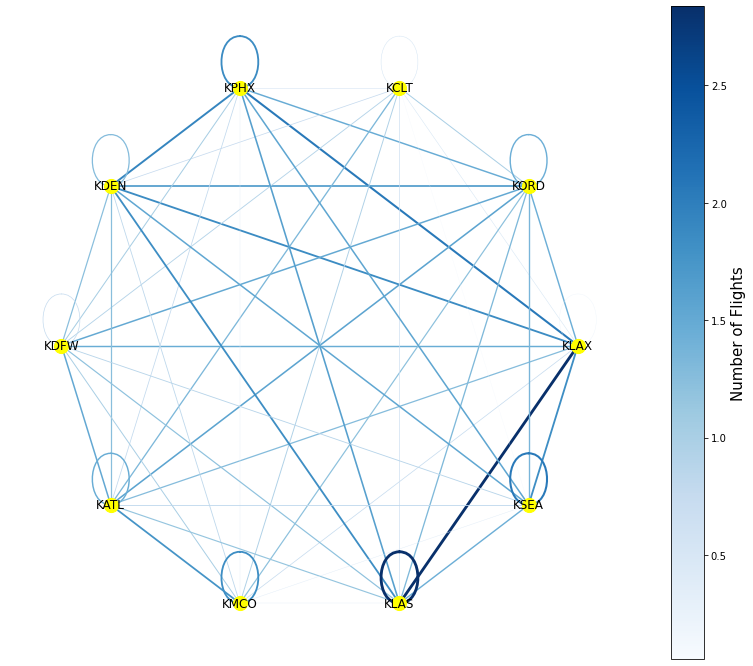

In [47]:
#Get a list of the edge weights and if needed, multiply by a scaling factor for visibility
scaling_factor = 0.001 #scaling factor for the edges, play with it till it works
edge_widths = [scaling_factor * G.edges[i]['Count'] for i in G.edges]
print(edge_widths)

fig, ax = plt.subplots(figsize = (14, 12)) #Create 14 (width) inches x 12 (height) inches figure (to make room for the colorbar)
cmap = plt.cm.Blues #store the colormap in the variable cmap
nx.draw(G, pos, ax = ax, node_color = 'yellow', node_size = 200, 
        width = edge_widths, edge_color = edge_widths, edge_cmap=cmap,labels=numberToAirport, with_labels = True) #Draw the network with edge width based on the edge weight

vmin = min(edge_widths) #Calculate the min and max values of the colorbar
vmax = max(edge_widths)
#Plot and show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Number of Flights', fontsize = 15)
# plt.savefig('AirportNetworkGraph.png') #save the image

Now that we have the recent three months graph network, I want to see if it was different when covid first started. Lets look at the first three months of 2020 (Jan,Feb,March). Make sure to rewrite the path and make a folder called 2020gz that has all the 2020 gz data from OpenSky.

In [48]:
flightlist2020 = pd.concat(
    pd.read_csv(file, parse_dates=["firstseen", "lastseen", "day"])
    for file in Path("Desktop/Stats_M148/OpenSky/2020gz").glob("flightlist_*.csv.gz")
)

In [49]:
flightlist2020.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,CHH7903,NaN,780ef8,B-8287,A333,NaN,EGCC,2020-01-31 00:00:07+00:00,2020-02-01 05:03:20+00:00,2020-02-01 00:00:00+00:00,62.316595,-153.436221,10972.8,53.352573,-2.282253,NaN
1,LAN576,LA576,e80214,CC-BGA,B789,NaN,SKBO,2020-01-31 00:00:08+00:00,2020-02-01 00:03:33+00:00,2020-02-01 00:00:00+00:00,38.063810,-10.594164,10058.4,4.743530,-74.191884,2705.10
2,CES297,MU297,780d9e,B-2022,B77W,NaN,KJFK,2020-01-31 00:00:08+00:00,2020-02-01 02:11:45+00:00,2020-02-01 00:00:00+00:00,59.870682,33.374542,9448.8,40.666638,-73.835803,160.02
3,SVA870,NaN,7100bf,HZ-AK31,B77W,NaN,RPLL,2020-01-31 00:00:11+00:00,2020-02-01 08:45:10+00:00,2020-02-01 00:00:00+00:00,5.326042,100.201753,10668.0,14.493155,120.991757,68.58
4,QTR875,NaN,06a2af,A7-BEK,B77W,NaN,OTHH,2020-01-31 00:00:27+00:00,2020-02-01 02:25:51+00:00,2020-02-01 00:00:00+00:00,25.943390,52.706909,6400.8,25.248367,51.629893,0.00


In [51]:
flightlist2020.shape

(10911179, 16)

There are a lot of rows.

Lets rewrite the code from above, we will create a function to reduce the repetition of our code later.

In [52]:
flightlist2020 = flightlist2020[flightlist2020['origin'].notna() & flightlist2020['destination'].notna()]

In [53]:
flightlist2020 = pd.merge(flightlist2020, icao_codes, how="left", left_on = ["origin"], right_on=["ICAO"])
flightlist2020 = flightlist2020.rename(columns={"Country": "country_origin"}).drop(columns=["ICAO"])

flightlist2020 = pd.merge(flightlist2020, icao_codes, how="left", left_on = ["destination"], right_on=["ICAO"])
flightlist2020 = flightlist2020.rename(columns={"Country": "country_destination"}).drop(columns=["ICAO"])

print(f"Number of Flights: {len(flightlist2020)}")
print(f"Missing Values for Country Origin: {flightlist2020.country_origin.isnull().sum(axis = 0) / len(flightlist2020)}")
print(f"Missing Values for Country Destination: {flightlist2020.country_destination.isnull().sum(axis = 0) / len(flightlist2020)}")


Number of Flights: 6760527
Missing Values for Country Origin: 0.1586567141881099
Missing Values for Country Destination: 0.2205409430359497


In [54]:
flightlist2020 = flightlist2020[flightlist2020['country_origin'].notna() & flightlist2020['country_destination'].notna()]

flightlist2020['day'] = flightlist2020['day'].dt.date

subset2020 = flightlist2020[(flightlist2020['origin'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) & (flightlist2020['destination'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) ]

In [55]:
subset2020

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
208,DAL654,NaN,a90af1,N682DA,B752,KATL,KATL,2020-01-31 15:57:18+00:00,2020-02-01 00:42:16+00:00,2020-02-01,33.634644,-84.416943,304.8,33.620316,-84.466086,335.28,United States of America,United States of America
319,ANA176,NH176,86800a,JA736A,B77W,KORD,KLAX,2020-01-31 16:56:27+00:00,2020-02-01 16:34:57+00:00,2020-02-01,41.968781,-87.943934,304.8,33.952875,-118.394737,-15.24,United States of America,United States of America
567,CPZ6014,NaN,a1c997,N214NN,E75L,KLAX,KLAX,2020-01-31 19:11:04+00:00,2020-02-01 01:07:27+00:00,2020-02-01,33.936535,-118.412933,0.0,33.953666,-118.386269,53.34,United States of America,United States of America
596,DAL342,NaN,ab9de9,N848DN,B739,KATL,KSEA,2020-01-31 19:21:49+00:00,2020-02-01 00:28:49+00:00,2020-02-01,33.646561,-84.400234,304.8,47.458889,-122.317974,83.82,United States of America,United States of America
679,DAL2922,NaN,a8df06,N6707A,B752,KSEA,KATL,2020-01-31 19:55:39+00:00,2020-02-01 00:06:47+00:00,2020-02-01,47.442037,-122.308044,0.0,33.631850,-84.458599,320.04,United States of America,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759593,AAL2403,AA2403,acffb7,N937AN,B738,KDFW,KATL,2020-04-30 22:05:09+00:00,2020-04-30 23:43:39+00:00,2020-04-30,32.877751,-97.030409,304.8,33.631805,-84.402634,403.86,United States of America,United States of America
6759695,AAL1682,AA1682,ac7658,N9018E,A319,KORD,KATL,2020-04-30 22:11:48+00:00,2020-04-30 23:28:36+00:00,2020-04-30,41.979309,-87.848240,609.6,33.649521,-84.397533,381.00,United States of America,United States of America
6759817,QTR8131,NaN,06a1e7,NaN,NaN,KATL,KDFW,2020-04-30 22:21:06+00:00,2020-04-30 23:59:29+00:00,2020-04-30,33.634644,-84.436970,304.8,32.946625,-97.025812,342.90,United States of America,United States of America
6760108,THY6319,NaN,4b846d,TC-ACM,B744,KORD,KATL,2020-04-30 22:41:48+00:00,2020-04-30 23:58:29+00:00,2020-04-30,41.968658,-87.882768,304.8,33.631757,-84.410419,358.14,United States of America,United States of America


In [56]:
flightCount2020 = {}

In [57]:
flightCount2020 = collections.Counter(flight for flight in zip(subset2020["origin"],subset2020["destination"]))

In [58]:
flightCount2020

Counter({('KATL', 'KATL'): 787,
         ('KORD', 'KLAX'): 1920,
         ('KLAX', 'KLAX'): 182,
         ('KATL', 'KSEA'): 929,
         ('KSEA', 'KATL'): 909,
         ('KCLT', 'KDFW'): 935,
         ('KLAX', 'KATL'): 1963,
         ('KSEA', 'KSEA'): 324,
         ('KCLT', 'KLAS'): 449,
         ('KORD', 'KSEA'): 1494,
         ('KCLT', 'KLAX'): 417,
         ('KATL', 'KLAX'): 1766,
         ('KLAS', 'KATL'): 1386,
         ('KATL', 'KPHX'): 1226,
         ('KLAX', 'KORD'): 2441,
         ('KCLT', 'KDEN'): 299,
         ('KPHX', 'KATL'): 1102,
         ('KLAX', 'KDFW'): 2464,
         ('KSEA', 'KORD'): 1340,
         ('KORD', 'KPHX'): 1777,
         ('KATL', 'KDEN'): 897,
         ('KDEN', 'KSEA'): 1991,
         ('KDFW', 'KLAX'): 2070,
         ('KPHX', 'KSEA'): 2328,
         ('KLAS', 'KSEA'): 2044,
         ('KSEA', 'KLAX'): 2995,
         ('KSEA', 'KDFW'): 1088,
         ('KCLT', 'KPHX'): 582,
         ('KORD', 'KDFW'): 2639,
         ('KPHX', 'KORD'): 1745,
         ('KLAX', 'KS

In [59]:
dataFrameList2020 = []
for origin,destination in flightCount2020:
        dataFrameList2020.append(
        {
            'Origin': origin,
            'Destination': destination,
            'Count': flightCount2020[origin,destination]
        }
    )

In [62]:
flightCountDF2020 = pd.DataFrame(dataFrameList2020)

In [63]:
flightCountDF2020

,Origin,Destination,Count
0,KATL,KATL,787
1,KORD,KLAX,1920
2,KLAX,KLAX,182
3,KATL,KSEA,929
4,KSEA,KATL,909
...,...,...,...
95,KMCO,KSEA,24
96,KMCO,KMCO,8
97,KMCO,KLAS,18
98,KMCO,KLAX,9


In [103]:
G = nx.from_pandas_edgelist(flightCountDF2020, "Origin", "Destination", ["Count"], create_using=nx.Graph)

In [65]:
pos = nx.circular_layout(G) #Uses the Fruchterman-Reingold force-directed algorith, to position nodes and minimize overlapping
pos 

{'KATL': array([1.00000000e+00, 2.66236709e-08]),
 'KORD': array([0.809017  , 0.58778527]),
 'KLAX': array([0.30901698, 0.95105656]),
 'KSEA': array([-0.30901702,  0.9510565 ]),
 'KCLT': array([-0.80901705,  0.58778521]),
 'KDFW': array([-9.99999982e-01, -6.07991049e-08]),
 'KLAS': array([-0.80901693, -0.58778533]),
 'KPHX': array([-0.30901708, -0.95105645]),
 'KDEN': array([ 0.30901713, -0.95105645]),
 'KMCO': array([ 0.80901694, -0.58778527])}

In [67]:
G.edges(data=True)

EdgeDataView([('KATL', 'KATL', {'Count': 787}), ('KATL', 'KSEA', {'Count': 909}), ('KATL', 'KLAX', {'Count': 1766}), ('KATL', 'KLAS', {'Count': 1385}), ('KATL', 'KPHX', {'Count': 1102}), ('KATL', 'KDEN', {'Count': 1721}), ('KATL', 'KDFW', {'Count': 2217}), ('KATL', 'KORD', {'Count': 2453}), ('KATL', 'KCLT', {'Count': 1101}), ('KATL', 'KMCO', {'Count': 238}), ('KORD', 'KLAX', {'Count': 2441}), ('KORD', 'KSEA', {'Count': 1340}), ('KORD', 'KPHX', {'Count': 1745}), ('KORD', 'KDFW', {'Count': 2578}), ('KORD', 'KLAS', {'Count': 1402}), ('KORD', 'KDEN', {'Count': 564}), ('KORD', 'KCLT', {'Count': 870}), ('KORD', 'KORD', {'Count': 573}), ('KORD', 'KMCO', {'Count': 91}), ('KLAX', 'KLAX', {'Count': 182}), ('KLAX', 'KCLT', {'Count': 462}), ('KLAX', 'KDFW', {'Count': 2070}), ('KLAX', 'KSEA', {'Count': 3089}), ('KLAX', 'KDEN', {'Count': 1269}), ('KLAX', 'KPHX', {'Count': 2624}), ('KLAX', 'KLAS', {'Count': 3524}), ('KLAX', 'KMCO', {'Count': 9}), ('KSEA', 'KSEA', {'Count': 324}), ('KSEA', 'KDEN', {'C

This time, we won't convert the airport strings to number as networkx doesn't require the nodes to be numerical inputs.

Now we can plot the networks for 2020, I commented out the savefigure code but if you want to save the figure on your computer, you can uncomment the last line.

[0.787, 0.909, 1.766, 1.385, 1.102, 1.721, 2.217, 2.453, 1.101, 0.23800000000000002, 2.441, 1.34, 1.745, 2.578, 1.4020000000000001, 0.5640000000000001, 0.87, 0.5730000000000001, 0.091, 0.182, 0.462, 2.07, 3.089, 1.2690000000000001, 2.624, 3.524, 0.009000000000000001, 0.324, 1.106, 2.371, 2.1, 1.23, 0.158, 0.024, 0.748, 0.36, 0.447, 0.47700000000000004, 0.356, 0.109, 1.617, 1.811, 1.949, 0.754, 0.135, 1.215, 2.575, 2.076, 0.018000000000000002, 3.043, 0.557, 0.034, 0.02, 0.217, 0.008]


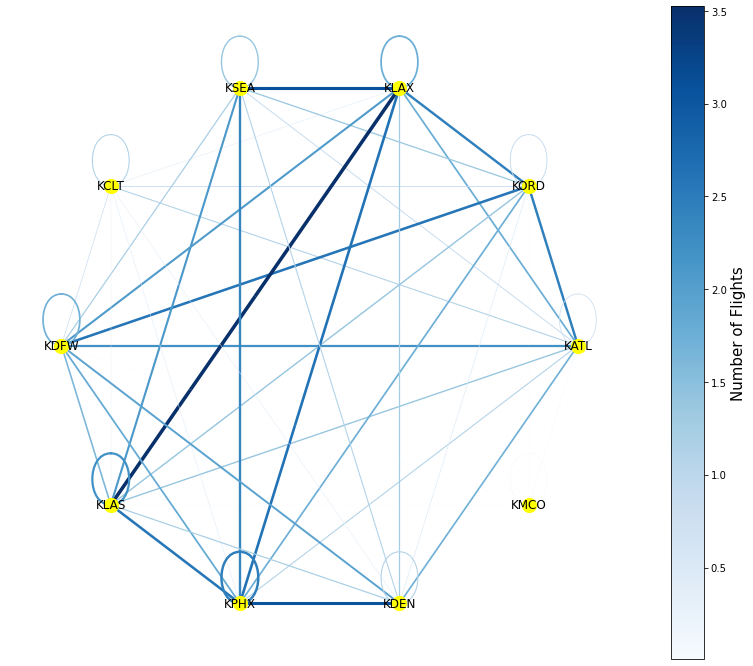

In [70]:
#Get a list of the edge weights and if needed, multiply by a scaling factor for visibility
scaling_factor = 0.001 #scaling factor for the edges, play with it till it works
edge_widths = [scaling_factor * G.edges[i]['Count'] for i in G.edges]
print(edge_widths)

fig, ax = plt.subplots(figsize = (14, 12)) #Create 14 (width) inches x 12 (height) inches figure (to make room for the colorbar)
cmap = plt.cm.Blues #store the colormap in the variable cmap
nx.draw(G, pos, ax = ax, node_color = 'yellow', node_size = 200, 
        width = edge_widths, edge_color = edge_widths, edge_cmap=cmap, with_labels = True) #Draw the network with edge width based on the edge weight

vmin = min(edge_widths) #Calculate the min and max values of the colorbar
vmax = max(edge_widths)
#Plot and show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Number of Flights', fontsize = 15)
# plt.savefig('2020AirportNetworkGraph.png') #save the image

In [73]:
scaling_factor = 0.01 #scaling factor for the edges, play with it till it works
edge_widths = [scaling_factor * G.edges[i]['Count'] for i in G.edges]
print(edge_widths)

[7.87, 9.09, 17.66, 13.85, 11.02, 17.21, 22.17, 24.53, 11.01, 2.38, 24.41, 13.4, 17.45, 25.78, 14.02, 5.64, 8.700000000000001, 5.73, 0.91, 1.82, 4.62, 20.7, 30.89, 12.69, 26.240000000000002, 35.24, 0.09, 3.24, 11.06, 23.71, 21.0, 12.3, 1.58, 0.24, 7.48, 3.6, 4.47, 4.7700000000000005, 3.56, 1.09, 16.17, 18.11, 19.490000000000002, 7.54, 1.35, 12.15, 25.75, 20.76, 0.18, 30.43, 5.57, 0.34, 0.2, 2.17, 0.08]


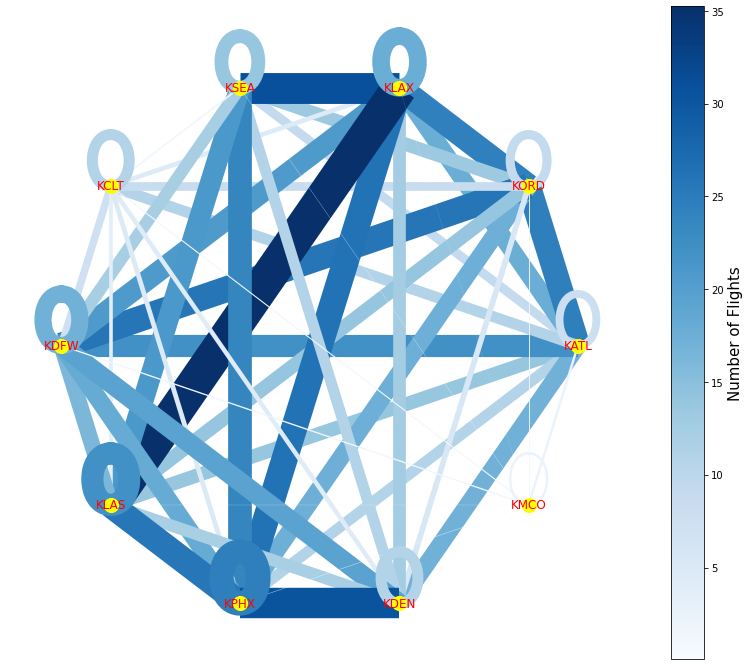

In [74]:
fig, ax = plt.subplots(figsize = (14, 12)) #Create 14 (width) inches x 12 (height) inches figure (to make room for the colorbar)
cmap = plt.cm.Blues #store the colormap in the variable cmap
nx.draw(G, pos, ax = ax, node_color = 'yellow', node_size = 200, 
        width = edge_widths, edge_color = edge_widths, edge_cmap=cmap, with_labels = True,font_color="red") #Draw the network with edge width based on the edge weight

vmin = min(edge_widths) #Calculate the min and max values of the colorbar
vmax = max(edge_widths)
#Plot and show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Number of Flights', fontsize = 15)
# plt.savefig('2020ThickAirportNetworkGraph.png') #save the image

It is kind of hard to see the difference between flight counts for the first three months of January, February, and March. Let's try to break them apart and look at two months at a time. Lets look at just January and February 2020, when the Covid Outbreak was at it's earliest stage in the United States.

In [6]:
flightlist2020 = pd.concat(
    pd.read_csv(file, parse_dates=["firstseen", "lastseen", "day"])
    for file in Path("Desktop/Stats_M148/OpenSky/2020JanFebgz").glob("flightlist_*.csv.gz")
)

In [7]:
flightlist2020.head()

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,CHH7903,NaN,780ef8,B-8287,A333,NaN,EGCC,2020-01-31 00:00:07+00:00,2020-02-01 05:03:20+00:00,2020-02-01 00:00:00+00:00,62.316595,-153.436221,10972.8,53.352573,-2.282253,NaN
1,LAN576,LA576,e80214,CC-BGA,B789,NaN,SKBO,2020-01-31 00:00:08+00:00,2020-02-01 00:03:33+00:00,2020-02-01 00:00:00+00:00,38.063810,-10.594164,10058.4,4.743530,-74.191884,2705.10
2,CES297,MU297,780d9e,B-2022,B77W,NaN,KJFK,2020-01-31 00:00:08+00:00,2020-02-01 02:11:45+00:00,2020-02-01 00:00:00+00:00,59.870682,33.374542,9448.8,40.666638,-73.835803,160.02
3,SVA870,NaN,7100bf,HZ-AK31,B77W,NaN,RPLL,2020-01-31 00:00:11+00:00,2020-02-01 08:45:10+00:00,2020-02-01 00:00:00+00:00,5.326042,100.201753,10668.0,14.493155,120.991757,68.58
4,QTR875,NaN,06a2af,A7-BEK,B77W,NaN,OTHH,2020-01-31 00:00:27+00:00,2020-02-01 02:25:51+00:00,2020-02-01 00:00:00+00:00,25.943390,52.706909,6400.8,25.248367,51.629893,0.00


In [8]:
flightlist2020.shape

(5383626, 16)

In [12]:
flightlist2020 = flightlist2020[flightlist2020['origin'].notna() & flightlist2020['destination'].notna()]

In [13]:
flightlist2020 = pd.merge(flightlist2020, icao_codes, how="left", left_on = ["origin"], right_on=["ICAO"])
flightlist2020 = flightlist2020.rename(columns={"Country": "country_origin"}).drop(columns=["ICAO"])

flightlist2020 = pd.merge(flightlist2020, icao_codes, how="left", left_on = ["destination"], right_on=["ICAO"])
flightlist2020 = flightlist2020.rename(columns={"Country": "country_destination"}).drop(columns=["ICAO"])

print(f"Number of Flights: {len(flightlist2020)}")
print(f"Missing Values for Country Origin: {flightlist2020.country_origin.isnull().sum(axis = 0) / len(flightlist2020)}")
print(f"Missing Values for Country Destination: {flightlist2020.country_destination.isnull().sum(axis = 0) / len(flightlist2020)}")


Number of Flights: 3187045
Missing Values for Country Origin: 0.11691111986181557
Missing Values for Country Destination: 0.17588393009825717


In [14]:
flightlist2020 = flightlist2020[flightlist2020['country_origin'].notna() & flightlist2020['country_destination'].notna()]

flightlist2020['day'] = flightlist2020['day'].dt.date

subset2020 = flightlist2020[(flightlist2020['origin'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) & (flightlist2020['destination'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) ]

In [15]:
subset2020

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,country_origin,country_destination
208,DAL654,NaN,a90af1,N682DA,B752,KATL,KATL,2020-01-31 15:57:18+00:00,2020-02-01 00:42:16+00:00,2020-02-01,33.634644,-84.416943,304.8,33.620316,-84.466086,335.28,United States of America,United States of America
319,ANA176,NH176,86800a,JA736A,B77W,KORD,KLAX,2020-01-31 16:56:27+00:00,2020-02-01 16:34:57+00:00,2020-02-01,41.968781,-87.943934,304.8,33.952875,-118.394737,-15.24,United States of America,United States of America
567,CPZ6014,NaN,a1c997,N214NN,E75L,KLAX,KLAX,2020-01-31 19:11:04+00:00,2020-02-01 01:07:27+00:00,2020-02-01,33.936535,-118.412933,0.0,33.953666,-118.386269,53.34,United States of America,United States of America
596,DAL342,NaN,ab9de9,N848DN,B739,KATL,KSEA,2020-01-31 19:21:49+00:00,2020-02-01 00:28:49+00:00,2020-02-01,33.646561,-84.400234,304.8,47.458889,-122.317974,83.82,United States of America,United States of America
679,DAL2922,NaN,a8df06,N6707A,B752,KSEA,KATL,2020-01-31 19:55:39+00:00,2020-02-01 00:06:47+00:00,2020-02-01,47.442037,-122.308044,0.0,33.631850,-84.458599,320.04,United States of America,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3186389,N888TV,NaN,ac3d4a,N888TV,AS50,KORD,KORD,2020-01-31 22:54:07+00:00,2020-01-31 23:35:08+00:00,2020-01-31,41.886912,-87.981262,304.8,41.888774,-87.977238,411.48,United States of America,United States of America
3186438,SWA2352,NaN,aa963e,N781WN,B737,KLAS,KLAX,2020-01-31 22:56:30+00:00,2020-01-31 23:38:23+00:00,2020-01-31,36.081103,-115.163542,304.8,33.953852,-118.384666,53.34,United States of America,United States of America
3186462,N661JM,NaN,a8b8c4,N661JM,E35L,KPHX,KLAS,2020-01-31 22:57:15+00:00,2020-01-31 23:44:58+00:00,2020-01-31,33.428836,-112.014247,0.0,36.073608,-115.133286,518.16,United States of America,United States of America
3186635,SWA1921,NaN,ad01ab,N937WN,B737,KLAS,KPHX,2020-01-31 23:06:09+00:00,2020-01-31 23:49:16+00:00,2020-01-31,36.079651,-115.164413,304.8,33.440847,-111.995694,266.70,United States of America,United States of America


In [16]:
flightCount2020 = {}

In [17]:
flightCount2020 = collections.Counter(flight for flight in zip(subset2020["origin"],subset2020["destination"]))

In [18]:
flightCount2020

Counter({('KATL', 'KATL'): 423,
         ('KORD', 'KLAX'): 933,
         ('KLAX', 'KLAX'): 116,
         ('KATL', 'KSEA'): 383,
         ('KSEA', 'KATL'): 384,
         ('KCLT', 'KDFW'): 393,
         ('KLAX', 'KATL'): 959,
         ('KSEA', 'KSEA'): 193,
         ('KCLT', 'KLAS'): 232,
         ('KORD', 'KSEA'): 655,
         ('KCLT', 'KLAX'): 194,
         ('KATL', 'KLAX'): 819,
         ('KLAS', 'KATL'): 727,
         ('KATL', 'KPHX'): 640,
         ('KLAX', 'KORD'): 1151,
         ('KCLT', 'KDEN'): 154,
         ('KPHX', 'KATL'): 595,
         ('KLAX', 'KDFW'): 1132,
         ('KSEA', 'KORD'): 639,
         ('KORD', 'KPHX'): 860,
         ('KATL', 'KDEN'): 475,
         ('KDEN', 'KSEA'): 879,
         ('KDFW', 'KLAX'): 940,
         ('KPHX', 'KSEA'): 1069,
         ('KLAS', 'KSEA'): 1038,
         ('KSEA', 'KLAX'): 1530,
         ('KSEA', 'KDFW'): 452,
         ('KCLT', 'KPHX'): 277,
         ('KORD', 'KDFW'): 1182,
         ('KPHX', 'KORD'): 875,
         ('KLAX', 'KSEA'): 1486,
 

In [19]:
dataFrameList2020 = []
for origin,destination in flightCount2020:
        dataFrameList2020.append(
        {
            'Origin': origin,
            'Destination': destination,
            'Count': flightCount2020[origin,destination]
        }
    )

In [20]:
flightCountDF2020 = pd.DataFrame(dataFrameList2020)

In [21]:
flightCountDF2020

,Origin,Destination,Count
0,KATL,KATL,423
1,KORD,KLAX,933
2,KLAX,KLAX,116
3,KATL,KSEA,383
4,KSEA,KATL,384
...,...,...,...
90,KMCO,KATL,10
91,KMCO,KORD,1
92,KMCO,KCLT,1
93,KMCO,KPHX,1


In [22]:
G = nx.from_pandas_edgelist(flightCountDF2020, "Origin", "Destination", ["Count"], create_using=nx.Graph)

In [23]:
pos = nx.circular_layout(G) #Uses the Fruchterman-Reingold force-directed algorith, to position nodes and minimize overlapping
pos 

{'KATL': array([1.00000000e+00, 2.66236709e-08]),
 'KORD': array([0.809017  , 0.58778527]),
 'KLAX': array([0.30901698, 0.95105656]),
 'KSEA': array([-0.30901702,  0.9510565 ]),
 'KCLT': array([-0.80901705,  0.58778521]),
 'KDFW': array([-9.99999982e-01, -6.07991049e-08]),
 'KLAS': array([-0.80901693, -0.58778533]),
 'KPHX': array([-0.30901708, -0.95105645]),
 'KDEN': array([ 0.30901713, -0.95105645]),
 'KMCO': array([ 0.80901694, -0.58778527])}

In [24]:
G.edges(data=True)

EdgeDataView([('KATL', 'KATL', {'Count': 423}), ('KATL', 'KSEA', {'Count': 384}), ('KATL', 'KLAX', {'Count': 819}), ('KATL', 'KLAS', {'Count': 730}), ('KATL', 'KPHX', {'Count': 595}), ('KATL', 'KDEN', {'Count': 827}), ('KATL', 'KDFW', {'Count': 1041}), ('KATL', 'KORD', {'Count': 1215}), ('KATL', 'KCLT', {'Count': 452}), ('KATL', 'KMCO', {'Count': 10}), ('KORD', 'KLAX', {'Count': 1151}), ('KORD', 'KSEA', {'Count': 639}), ('KORD', 'KPHX', {'Count': 875}), ('KORD', 'KDFW', {'Count': 1164}), ('KORD', 'KLAS', {'Count': 729}), ('KORD', 'KDEN', {'Count': 285}), ('KORD', 'KCLT', {'Count': 349}), ('KORD', 'KORD', {'Count': 425}), ('KORD', 'KMCO', {'Count': 1}), ('KLAX', 'KLAX', {'Count': 116}), ('KLAX', 'KCLT', {'Count': 187}), ('KLAX', 'KDFW', {'Count': 940}), ('KLAX', 'KSEA', {'Count': 1486}), ('KLAX', 'KDEN', {'Count': 646}), ('KLAX', 'KPHX', {'Count': 1217}), ('KLAX', 'KLAS', {'Count': 1994}), ('KLAX', 'KMCO', {'Count': 39}), ('KSEA', 'KSEA', {'Count': 193}), ('KSEA', 'KDEN', {'Count': 507}

We can calculate the max and min count number of flights to be able to get the range for our colorbar in our graph.

In [25]:
#The max is 1994
max(list(zip(*G.edges.data("Count")))[2])

1994

In [26]:
min(list(zip(*G.edges.data("Count")))[2])

1

[0.423, 0.384, 0.8190000000000001, 0.73, 0.595, 0.8270000000000001, 1.041, 1.215, 0.452, 0.01, 1.151, 0.639, 0.875, 1.164, 0.729, 0.28500000000000003, 0.34900000000000003, 0.425, 0.001, 0.116, 0.187, 0.9400000000000001, 1.486, 0.646, 1.217, 1.994, 0.039, 0.193, 0.507, 1.098, 1.074, 0.496, 0.065, 0.029, 0.26, 0.17300000000000001, 0.189, 0.195, 0.082, 0.001, 0.806, 0.804, 0.91, 0.40800000000000003, 0.001, 0.5640000000000001, 1.428, 1.293, 0.015, 1.34, 0.20700000000000002, 0.001, 0.079, 0.135]


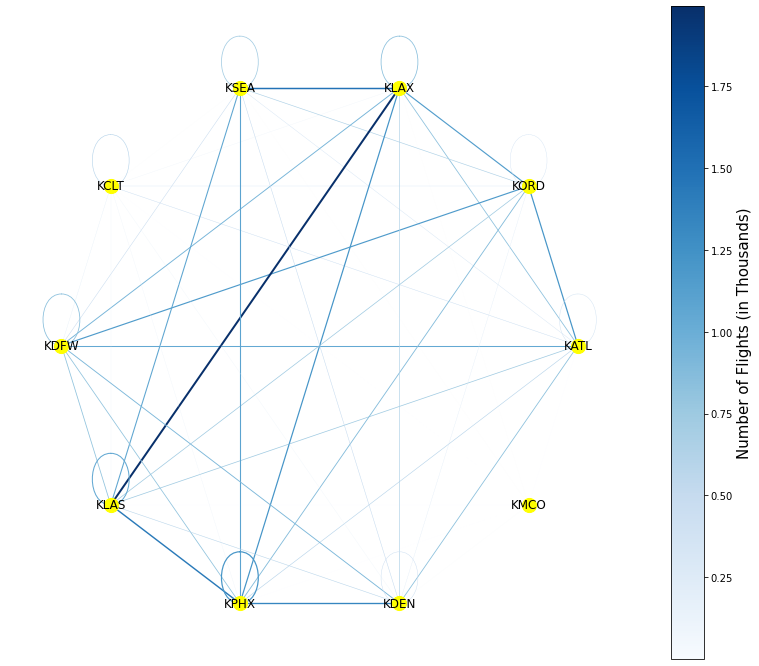

In [27]:
#Get a list of the edge weights and if needed, multiply by a scaling factor for visibility
scaling_factor = 0.001 #scaling factor for the edges, play with it till it works
edge_widths = [scaling_factor * G.edges[i]['Count'] for i in G.edges]
print(edge_widths)

fig, ax = plt.subplots(figsize = (14, 12)) #Create 14 (width) inches x 12 (height) inches figure (to make room for the colorbar)
cmap = plt.cm.Blues #store the colormap in the variable cmap
nx.draw(G, pos, ax = ax, node_color = 'yellow', node_size = 200, 
        width = edge_widths, edge_color = edge_widths, edge_cmap=cmap, with_labels = True) #Draw the network with edge width based on the edge weight

vmin = min(edge_widths) #Calculate the min and max values of the colorbar
vmax = max(edge_widths)
#Plot and show the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Number of Flights (in Thousands)', fontsize = 15)
plt.savefig('2020JanFebAirportNetworkGraph.png') #save the image

Now lets do March and April. Lets try to make a function to reduce code redudancy.

First lets fix our pos from the pos we got above for our graph G

In [28]:
pos = nx.circular_layout(G)

Then lets create a function that takes a string of the path of the data and returns a flightDF

In [29]:
def getDataFrame(path):
    '''
    Give a string of the path to the dataset and returns the dataframe
    '''
    flightDF = pd.concat(
    pd.read_csv(file, parse_dates=["firstseen", "lastseen", "day"])
    for file in Path(path).glob("flightlist_*.csv.gz"))
    return flightDF

We can easily get the data for January and February, March and April, and May and June.

In [30]:
JanFeb = getDataFrame("Desktop/Stats_M148/OpenSky/2020JanFebgz")

In [31]:
MarApril = getDataFrame("Desktop/Stats_M148/OpenSky/2020MarchAprilgz")

Now we will download figure and text from pyplot to make our labels for our nodes bigger.

In [60]:
from matplotlib.pyplot import figure, text

We will now create a function that will generate the airport connection graph. When the range for the colorbar is created, sometimes the numbers get cut off by in the hundreds. I replaced the specific number instead of using vmin and vmax. This will need to be fixed to make the function more reusable. (On the last few lines, you can see that I inputted specific values for vmin and vmax, this should be fixed by using a round function norm=plt.Normalize(vmin = 1, vmax=700)). Another flaw of this function is that it needs a fixed list of position for the nodes passed in, which means that we must create the graph and generate the positions outside the function beforehand.

In [85]:
def generateAirportConnectionGraph(df,daterange,pos,savefigname,colorbarspec):
    '''
    Requires collections and pandas to run. df is a DataFrame, daterange is a string, savefigname is a string, and colorbarspec is a string of the color we want for our colorbar.
    '''
    flightlist2020 = df
    
    flightlist2020 = flightlist2020[flightlist2020['origin'].notna() & flightlist2020['destination'].notna()]
    
    flightlist2020 = pd.merge(flightlist2020, icao_codes, how="left", left_on = ["origin"], right_on=["ICAO"])
    flightlist2020 = flightlist2020.rename(columns={"Country": "country_origin"}).drop(columns=["ICAO"])

    flightlist2020 = pd.merge(flightlist2020, icao_codes, how="left", left_on = ["destination"], right_on=["ICAO"])
    flightlist2020 = flightlist2020.rename(columns={"Country": "country_destination"}).drop(columns=["ICAO"])

    print(f"Number of Flights: {len(flightlist2020)}")
    print(f"Missing Values for Country Origin: {flightlist2020.country_origin.isnull().sum(axis = 0) / len(flightlist2020)}")
    print(f"Missing Values for Country Destination: {flightlist2020.country_destination.isnull().sum(axis = 0) / len(flightlist2020)}")

    flightlist2020 = flightlist2020[flightlist2020['country_origin'].notna() & flightlist2020['country_destination'].notna()]

    flightlist2020['day'] = flightlist2020['day'].dt.date

    subset2020 = flightlist2020[(flightlist2020['origin'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) & (flightlist2020['destination'].isin(["KATL", "KDFW", "KDEN", "KORD", "KLAX", "KCLT", "KLAS", "KPHX", "KMCO", "KSEA"])) ]
    
    flightCount2020 = {}
    
    flightCount2020 = collections.Counter(flight for flight in zip(subset2020["origin"],subset2020["destination"]))
    
    dataFrameList2020 = []
    for origin,destination in flightCount2020:
            dataFrameList2020.append(
            {
                'Origin': origin,
                'Destination': destination,
                'Count': flightCount2020[origin,destination]
            }
        )
            
    flightCountDF2020 = pd.DataFrame(dataFrameList2020)
    
    G = nx.from_pandas_edgelist(flightCountDF2020, "Origin", "Destination", ["Count"], create_using=nx.Graph)
    
    # pos = nx.circular_layout(G) #Uses the Fruchterman-Reingold force-directed algorith, to position nodes and minimize overlapping

    #Get a list of the edge weights and if needed, multiply by a scaling factor for visibility
    scaling_factor = 0.01 #scaling factor for the edges, play with it till it works
    edge_widths = [scaling_factor * G.edges[i]['Count'] for i in G.edges]
    print(f"THIS IS THE EDGE WIDTHS{edge_widths}")
    print(f"THIS IS THE LENGTH OF EDGE_WIDTHS LIST: {len(edge_widths)}")

    d = dict(G.degree)
    
    fig, ax = plt.subplots(figsize = (14, 12)) #Create 14 (width) inches x 12 (height) inches figure (to make room for the colorbar)
    cmap = colorbarspec #store the colormap in the variable cmap
    nx.draw(G, pos, ax = ax, node_color = 'yellow', node_size = 5000, 
            width = edge_widths, edge_color = edge_widths, edge_cmap=cmap, with_labels = False) #Draw the network with edge width based on the edge weight

    for node, (x, y) in pos.items():
        text(x, y, node, fontsize=d[node]*1.5, ha='center', va='center')
    
    print("The max number of flights:")
    print(max(list(zip(*G.edges.data("Count")))[2]))
    print("The min number of flights:")
    print(min(list(zip(*G.edges.data("Count")))[2]))
    vmin = min(edge_widths) #Calculate the min and max values of the colorbar
    vmax = max(edge_widths)
    #Plot and show the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 1, vmax=700))
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel('Number of Flights', fontsize = 25)
    plt.title("    The Number of Flights Network for Top Ten Busiest US Airports "+ "\n" + "from " + daterange, fontsize=20)
    plt.savefig(savefigname)

Here are the colormaps for the colorbar spec :https://matplotlib.org/stable/tutorials/colors/colormaps.html

With our newly create function, we can now generate the graphs and save them easily.

Number of Flights: 1882174
Missing Values for Country Origin: 0.15395707304425627
Missing Values for Country Destination: 0.2217823644360192
THIS IS THE EDGE WIDTHS[1.31, 8.57, 1.93, 4.38, 6.23, 4.34, 0.35000000000000003, 8.07, 7.640000000000001, 2.7600000000000002, 1.27, 6.22, 7.640000000000001, 9.540000000000001, 4.19, 0.47000000000000003, 11.98, 9.23, 0.05, 2.5300000000000002, 1.83, 3.24, 5.51, 5.2, 0.37, 7.04, 4.5200000000000005, 0.6, 3.74, 3.5300000000000002, 5.3500000000000005, 5.5600000000000005, 0.04, 1.4000000000000001, 0.97, 1.35, 3.12, 0.5, 0.6, 0.07, 0.05, 4.04, 5.88, 6.67, 2.98, 3.58, 7.3, 0.07, 1.82, 1.12, 2.86, 0.03, 0.6, 2.44, 0.01]
THIS IS THE LENGTH OF EDGE_WIDTHS LIST: 55
The max number of flights:
1198
The min number of flights:
1


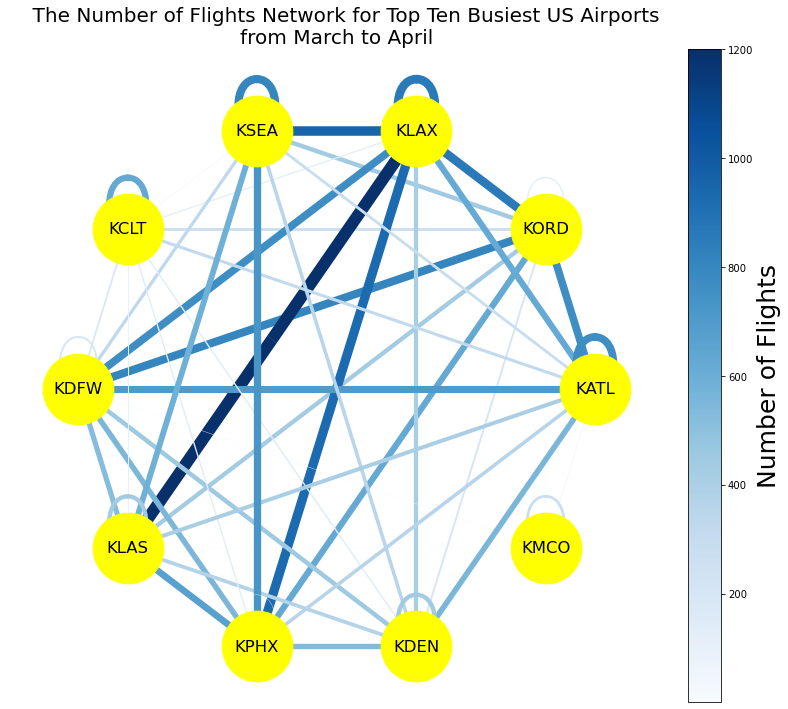

In [82]:
generateAirportConnectionGraph(MarApril,"March to April",pos,"MarchApril.png",plt.cm.Blues)

Number of Flights: 3187045
Missing Values for Country Origin: 0.11691111986181557
Missing Values for Country Destination: 0.17588393009825717
THIS IS THE EDGE WIDTHS[4.23, 3.84, 8.19, 7.3, 5.95, 8.27, 10.41, 12.15, 4.5200000000000005, 0.1, 11.51, 6.390000000000001, 8.75, 11.64, 7.29, 2.85, 3.49, 4.25, 0.01, 1.16, 1.87, 9.4, 14.86, 6.46, 12.17, 19.94, 0.39, 1.93, 5.07, 10.98, 10.74, 4.96, 0.65, 0.29, 2.6, 1.73, 1.8900000000000001, 1.95, 0.8200000000000001, 0.01, 8.06, 8.040000000000001, 9.1, 4.08, 0.01, 5.64, 14.280000000000001, 12.93, 0.15, 13.4, 2.07, 0.01, 0.79, 1.35]
THIS IS THE LENGTH OF EDGE_WIDTHS LIST: 54
The max number of flights:
1994
The min number of flights:
1


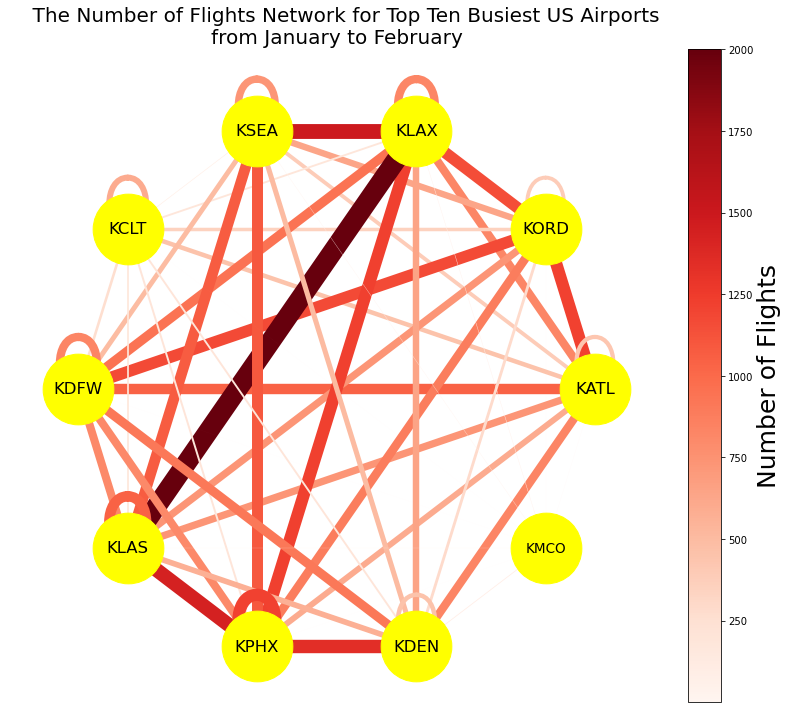

In [84]:
generateAirportConnectionGraph(JanFeb,"January to February",pos,"JanFeb.png",plt.cm.Reds)

In [72]:
MayJune = getDataFrame("Desktop/Stats_M148/OpenSky/2020MayJunegz")

Number of Flights: 1691308
Missing Values for Country Origin: 0.24255073588015902
Missing Values for Country Destination: 0.30330962781468546
THIS IS THE EDGE WIDTHS[2.5100000000000002, 0.9, 2.39, 4.18, 2.77, 3.0300000000000002, 5.01, 4.98, 0.18, 4.8500000000000005, 3.71, 2.49, 1.49, 4.74, 1.2, 3.75, 5.04, 0.9, 0.15, 0.43, 2.14, 3.0500000000000003, 2.65, 1.47, 1.02, 0.39, 1.01, 5.11, 5.68, 3.0300000000000002, 5.99, 2.04, 0.19, 0.04, 2.63, 5.29, 2.46, 3.77, 0.19, 0.05, 2.47, 0.86, 6.3500000000000005, 0.06, 0.17, 4.5600000000000005, 2.73, 1.68, 0.26, 1.4000000000000001, 0.12, 0.93, 0.22, 0.16, 0.07]
THIS IS THE LENGTH OF EDGE_WIDTHS LIST: 55
The max number of flights:
635
The min number of flights:
4


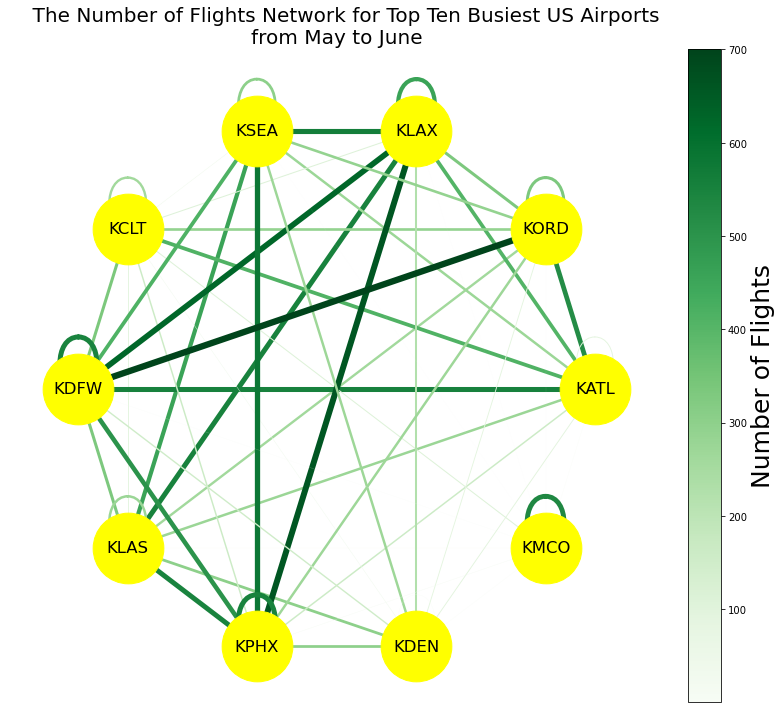

In [86]:
generateAirportConnectionGraph(MayJune,"May to June",pos,"MayJune.png",plt.cm.Greens)